## Brain image modeling

### Setup

In [1]:
import shutil
import os
import json
import shutil
import logging
import numpy
import pprint
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensor2tensor.utils import trainer_lib
from tensor2tensor import problems
from tensor2tensor.utils import registry
from tensor2tensor.data_generators import allen_brain
from tensor2tensor.data_generators import allen_brain_utils

import tensorflow as tf

from tensorflow.contrib.eager.python import tfe
tfe.enable_eager_execution()
Modes = tf.estimator.ModeKeys

from tk.util import hack_dict_to_cli_args
from tk import experiment
from tk import util

from tensorboard.backend.event_processing import event_file_loader
from protobuf_to_dict import protobuf_to_dict

logging.getLogger().setLevel(logging.INFO)


Instructions for updating:
Use the retry module or similar alternatives.


### TensorBoard

Start a TensorBoard deployment and service pointing to a log_dir parent to all log_dirs we will write for subsequent experiments, allowing us to compare logs from all experiments via a single TensorBoard instance.

In [ ]:
from tk import kube_tensorboard

tb = kube_tensorboard.TensorBoard(log_dir="/mnt/nfs-east1-d/comparisons",
                                  namespace="kubeflow")

tb.create()

### Training

In [10]:

def _stage(local_app_root, remote_app_root):
    if not os.path.exists(local_app_root):
        raise ValueError("Can't stage from a non-existent source, "
                         "saw %s" % local_app_root)
    shutil.copytree(local_app_root, remote_app_root)


def _configure_experiment(base_name, num_gpu_per_worker=1,
                          problem="img2img_allen_brain_dim8to32",
                          batch_size=4):

    app_root = "/mnt/nfs-east1-d/work/tk"

    output_dir = os.path.join(app_root, "output")

    job_name = util.generate_job_name(base_name)

    train_args = {
        "problem": problem,
        "model": "img2img_transformer",
        "hparams_set": "img2img_transformer2d_tiny",
        "data_dir": "/mnt/nfs-east1-d/data",
        "output_dir": output_dir,
        "train_steps": 1,
        "schedule": "train",
        "profile": False,
        "log_device_placement": False,
        "worker_gpu": num_gpu_per_worker,
        "save_checkpoints_secs": 1800,
        "dbgprofile": False, # Saves profiling timelines, viewable in chrome://tracing
        "ssd_mount_path": "/mnt/disks/ssd0",
        "worker_gpu_memory_fraction": 0.95,
        "hparams": "'batch_size=%s'" % batch_size
    }

    args = {
        "job_name": job_name,
        "volume_claim_id": "nfs-east1-d",
        "app_root": app_root,
        "gcp_project": "foo",
        "namespace": "kubeflow",
        "image": "tensorflow/tensorflow:latest-gpu",
        "smoke": True,
        "batch": False,
        "train_args": train_args,
        "cpu": 7,
        "memory": "40Gi",
        "num_gpu": num_gpu_per_worker,
        "num_local_ssd": 1,
        "no_wait": True,
        "num_worker_replicas": 0,
        "num_ps_replicas": 0,
        "selector_labels": {
          "cloud.google.com/gke-nodepool": "train-gpu-preemptible-%sx-hm" % num_gpu_per_worker,
          "cloud.google.com/gke-accelerator": "nvidia-tesla-k80"
        }
    }

    local_app_root = args["app_root"]

    testing_storage_base = "/mnt/nfs-east1-d/comparisons/%s" % base_name
    remote_app_root = "%s/%s" % (testing_storage_base,
                                 args["job_name"])

    args["train_args"]["output_dir"] = os.path.join(remote_app_root,
                                                    "output")

    with open(os.path.join(local_app_root, "job.sh"), "w") as f:
      f.write("ls /mnt\n")
      f.write("cp -r /mnt/nfs-east1-d/data/* /mnt/ssd0/\n")
      f.write("pip install -e %s/vendor/tensor2tensor\n" % remote_app_root)
      f.write("pip install -e %s\n" % remote_app_root)
      f.write("nvidia-smi\n")
      f.write("python -c 'from tensorflow.python.client import device_lib; print(device_lib.list_local_devices())'\n")
      f.write("echo ${TF_CONFIG}\n")
      f.write("cd %s\n" % remote_app_root)
      cmd = ["python", "-m", "tk.experiment"]
      cmd.extend(hack_dict_to_cli_args(args["train_args"]))
      f.write(" ".join(cmd) + "\n")
      f.write("nvidia-smi\n")
      logging.info(local_app_root)

    _stage(local_app_root, remote_app_root)
    args["app_root"] = remote_app_root
    args["batch"] = True

    return args


In [11]:
comparison_base_name = "example"
args = _configure_experiment(comparison_base_name, batch_size=1)

[2018-07-05 20:40:25,972] /mnt/nfs-east1-d/work/tk


In [12]:
job = experiment.T2TExperiment(**args)
job.run()

[2018-07-05 20:41:29,244] smoke: True


In [18]:
!kubectl logs -n kubeflow example-j0705-2040-9fe3-master-kr9o-0-xw8ww

nfs-east1-d
ssd0
Obtaining file:///mnt/nfs-east1-d/comparisons/example/example-j0705-2040-9fe3/vendor/tensor2tensor
  Running setup.py bdist_wheel for bz2file: started
  Running setup.py bdist_wheel for bz2file: finished with status 'done'
  Stored in directory: /root/.cache/pip/wheels/81/75/d6/e1317bf09bf1af5a30befc2a007869fa6e1f516b8f7c591cb9
  Running setup.py bdist_wheel for future: started
  Running setup.py bdist_wheel for future: finished with status 'done'
  Stored in directory: /root/.cache/pip/wheels/bf/c9/a3/c538d90ef17cf7823fa51fc701a7a7a910a80f6a405bf15b1a
  Running setup.py bdist_wheel for gym: started
  Running setup.py bdist_wheel for gym: finished with status 'done'
  Stored in directory: /root/.cache/pip/wheels/cb/14/71/f4ab006b1e6ff75c2b54985c2f98d0644fffe9c1dddc670925
  Running setup.py bdist_wheel for sympy: started
  Running setup.py bdist_wheel for sympy: finished with status 'done'
  Stored in directory: /root/.cache/pip/wheels/6d/47/7c/40a7cd9b9bd5bad329fcd21d8

### Launch a single-node comparison run

In [4]:

for i in [1, 2, 4]:
  comparison_base_name = "multigpu-4"
  args = _configure_experiment(comparison_base_name, num_gpu_per_worker=i)
  job = experiment.T2TExperiment(**args)
  job.run()


[2018-07-02 19:21:16,814] /mnt/nfs-east1-d/work/tk
[2018-07-02 19:22:25,895] smoke: True
[2018-07-02 19:22:26,024] /mnt/nfs-east1-d/work/tk
[2018-07-02 19:23:32,711] smoke: True
[2018-07-02 19:23:32,839] /mnt/nfs-east1-d/work/tk
[2018-07-02 19:24:41,936] smoke: True
[2018-07-02 19:24:42,072] /mnt/nfs-east1-d/work/tk
[2018-07-02 19:25:48,886] smoke: True


### Visualize comparison results

In [3]:

def _event_dict_list_from_events_file(event_file_path):
    loader = event_file_loader.EventFileLoader(event_file_path)
    events = []
    for event in loader.Load():
      events.append(event)

    output_events = []

    for thing in events:
        d = protobuf_to_dict(thing)

        output_event = {}
        if "wall_time" in d:
            output_event["wall_time"] = d["wall_time"]
        if "step" in d:
            output_event["step"] = d["step"]
        if "summary" in d.keys():
            values = {}
            for value in d["summary"]["value"]:
                if "simple_value" in value.keys():
                    output_event[value["tag"]] = value["simple_value"]

        if "loss" in output_event:
            output_events.append(output_event)
    
    return output_events


def _event_data_for_comparison(comparison_root):
    event_data = []
    tf.logging.info("Identifying event files in experiment subdirectories...")
    paths = tf.gfile.Glob(os.path.join(comparison_root, "*/output/*/events.out*"))
    for i, experiment in enumerate(paths):
        tf.logging.info("Processing experiment events (%s of %s)" % (i + 1, len(paths)))
        event_list = _event_dict_list_from_events_file(experiment)
        event_dict = {"source_path": experiment,
                      "events": event_list}
        # TODO: Also read other experiment metadata
        event_data.append(event_dict)
    tf.logging.info("Finished loading event data for comparison.")
    return event_data


In [4]:

def show_experiment_loss(comparison_base_name):
    
    comparison_root = "/mnt/nfs-east1-d/comparisons/%s" % comparison_base_name
    experiments_data = _event_data_for_comparison(comparison_root)

    plt.figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
    for i, experiment_data in enumerate(experiments_data):
        wall_times = [event["wall_time"] for event in experiment_data["events"]]
        minwt = min(wall_times)
        relative_times = [wt - minwt for wt in wall_times]
        losses = [event["loss"] for event in experiment_data["events"]]
        plt.plot(relative_times, losses, label=str(i))

    plt.legend()
    plt.show()


INFO:tensorflow:Identifying event files in experiment subdirectories...


[2018-06-30 23:51:38,520] Identifying event files in experiment subdirectories...


INFO:tensorflow:Processing experiment events (1 of 4)


[2018-06-30 23:51:51,939] Processing experiment events (1 of 4)


INFO:tensorflow:Processing experiment events (2 of 4)


[2018-06-30 23:51:54,049] Processing experiment events (2 of 4)


INFO:tensorflow:Processing experiment events (3 of 4)


[2018-06-30 23:51:58,758] Processing experiment events (3 of 4)


INFO:tensorflow:Processing experiment events (4 of 4)


[2018-06-30 23:52:03,090] Processing experiment events (4 of 4)


INFO:tensorflow:Finished loading event data for comparison.


[2018-06-30 23:52:08,988] Finished loading event data for comparison.


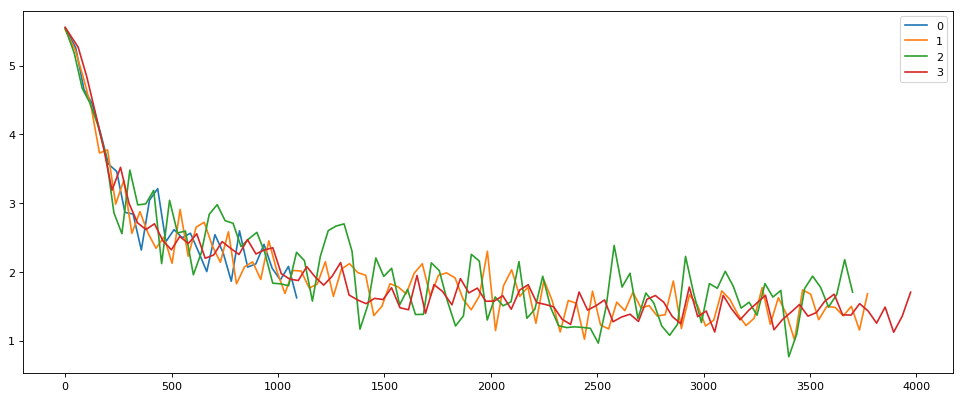

In [19]:

show_experiment_loss("multigpu-2")


In [ ]:

# Blue line was likely preempted

# So looking at this there wasn't a shift in training speed that I expected. Expected the loss
# curve to be more concave with additional GPUs.

# Worth repeating to compare. But do expect optimization to be smoother when processing more
# examples. Also the ability to process more examples is important because it should permit
# dialing back the batch size and increasing the problem size (currently is tiny 8->32px).

# One reason there might not be such a difference between conditions is because the problem
# isn't challenging enough.


INFO:tensorflow:Identifying event files in experiment subdirectories...


[2018-07-02 20:40:10,296] Identifying event files in experiment subdirectories...


INFO:tensorflow:Processing experiment events (1 of 3)


[2018-07-02 20:40:28,413] Processing experiment events (1 of 3)


INFO:tensorflow:Processing experiment events (2 of 3)


[2018-07-02 20:40:33,437] Processing experiment events (2 of 3)


INFO:tensorflow:Processing experiment events (3 of 3)


[2018-07-02 20:40:39,594] Processing experiment events (3 of 3)


INFO:tensorflow:Finished loading event data for comparison.


[2018-07-02 20:40:44,713] Finished loading event data for comparison.


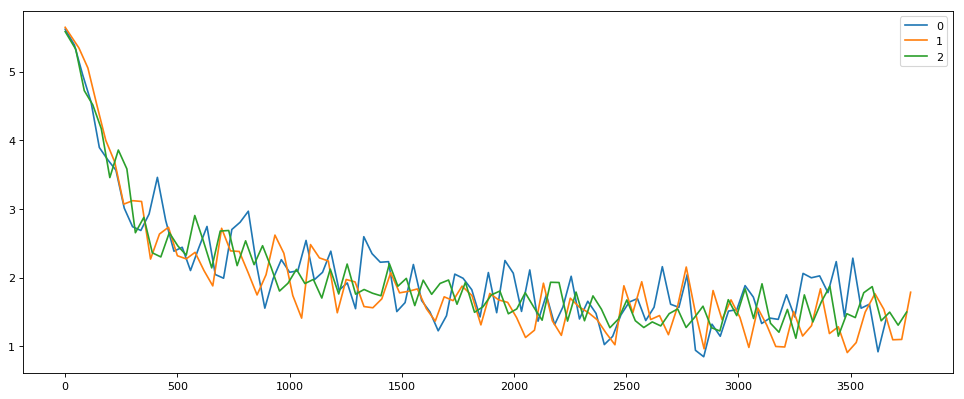

In [13]:

show_experiment_loss("multigpu-4")


In [ ]:

# Again looks to be a smoothing of the 4x condition, as expected.


In [15]:

# Haven't been able to run an 8x job yet - shows added node in cloud dashboard but not via
# kube api


### Launch a multi-node TFJob 

In [35]:

args = _configure_experiment("multinode-2", num_gpu_per_worker=2)
args["num_worker_replicas"] = 0
args["num_ps_replicas"] = 1

job = experiment.T2TExperiment(**args)
job.run()


[2018-07-02 18:53:46,667] /mnt/nfs-east1-d/work/tk
[2018-07-02 18:54:53,304] smoke: True


In [ ]:

show_experiment_loss("multinode-2")


### Larger problem

Checking whether we can run the larger problem at reduced or increased batch sizes without failing with GPU OOM.

In [13]:

for batch_size in [1, 2, 4, 8, 16]:

    args = _configure_experiment("larger-b%s" % batch_size,
                                 problem="img2img_allen_brain_dim48to64",
                                 num_gpu_per_worker=1,
                                 batch_size=batch_size)

    job = experiment.T2TExperiment(**args)
    job.run()


[2018-07-02 23:14:49,768] /mnt/nfs-east1-d/work/tk
[2018-07-02 23:16:03,244] smoke: True
[2018-07-02 23:16:03,392] /mnt/nfs-east1-d/work/tk
[2018-07-02 23:17:14,189] smoke: True
[2018-07-02 23:17:14,319] /mnt/nfs-east1-d/work/tk
[2018-07-02 23:18:25,418] smoke: True
[2018-07-02 23:18:25,542] /mnt/nfs-east1-d/work/tk
[2018-07-02 23:19:37,799] smoke: True
[2018-07-02 23:19:37,921] /mnt/nfs-east1-d/work/tk
[2018-07-02 23:20:52,217] smoke: True


In [ ]:

# All of the above conditions either crashed or were evicted except the batch_size=1 condition,
# presumably because of the intersection of the problem size, batch size, and limited size of K80
# GPU memory.

# Also b_size=[4, 8, and 16] still fail with n_gpu=4


### Inference

In [2]:
hparams_set = "img2img_transformer2d_tiny"
problem_name = "img2img_allen_brain_dim8to32"
model_name = "img2img_transformer"
data_dir = "/mnt/nfs-east1-d/data"

In [3]:
hp = trainer_lib.create_hparams(
    hparams_set,
    data_dir=data_dir,
    problem_name=problem_name)

model = registry.model(model_name)(hp, Modes.TRAIN)

problem_object = problems.problem(problem_name)

dataset = problem_object.dataset(Modes.TRAIN, data_dir)

INFO:tensorflow:Setting T2TModel mode to 'train'


[2018-07-06 02:42:27,316] Setting T2TModel mode to 'train'


INFO:tensorflow:Reading data files from /mnt/nfs-east1-d/data/img2img_allen_brain_dim8to32-train*


[2018-07-06 02:42:27,320] Reading data files from /mnt/nfs-east1-d/data/img2img_allen_brain_dim8to32-train*


INFO:tensorflow:partition: 0 num_data_files: 100


[2018-07-06 02:42:27,389] partition: 0 num_data_files: 100


In [73]:
for count, example in enumerate(tfe.Iterator(dataset)):
    # Get the 100th example, skipping background
    if count > 100:
        break

In [74]:

# TODO: Examples don't appear to be shuffled propperly! (The first 1725 are background)


In [75]:
example["inputs"] = tf.reshape(example["inputs"], [1, 8, 8, 3])
example["targets"] = tf.reshape(example["targets"], [1, 32, 32, 3])

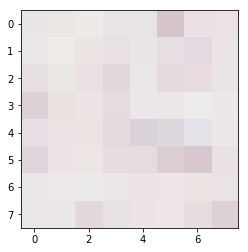

In [76]:
plt.imshow(example["inputs"].numpy()[0])

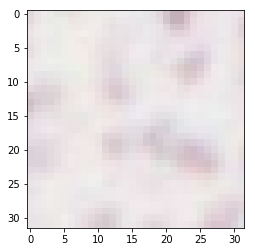

In [77]:
plt.imshow(example["targets"].numpy()[0])

In [78]:
example["inputs"].numpy()[0]

array([[[234, 230, 231],
        [235, 232, 228],
        [238, 234, 232],
        [233, 229, 231],
        [231, 227, 231],
        [213, 196, 204],
        [235, 224, 229],
        [234, 226, 230]],

       [[235, 231, 231],
        [239, 236, 232],
        [236, 229, 228],
        [232, 224, 228],
        [234, 229, 233],
        [230, 222, 227],
        [227, 217, 226],
        [235, 228, 229]],

       [[230, 224, 227],
        [233, 232, 229],
        [234, 226, 226],
        [225, 216, 221],
        [234, 232, 230],
        [229, 218, 219],
        [232, 220, 224],
        [234, 228, 230]],

       [[220, 209, 214],
        [233, 226, 225],
        [237, 229, 229],
        [229, 220, 223],
        [236, 231, 234],
        [235, 231, 233],
        [237, 235, 236],
        [236, 231, 233]],

       [[232, 222, 229],
        [236, 227, 229],
        [236, 228, 227],
        [227, 218, 221],
        [218, 210, 217],
        [221, 216, 222],
        [229, 225, 232],
        [235, 232

In [79]:
example["targets"].numpy()[0]

array([[[225, 216, 219],
        [233, 228, 230],
        [238, 235, 234],
        ...,
        [238, 232, 236],
        [236, 228, 234],
        [236, 224, 233]],

       [[227, 218, 221],
        [234, 228, 230],
        [237, 234, 233],
        ...,
        [236, 231, 235],
        [234, 226, 231],
        [228, 216, 222]],

       [[234, 225, 228],
        [238, 232, 234],
        [239, 237, 235],
        ...,
        [236, 231, 235],
        [233, 225, 230],
        [223, 211, 218]],

       ...,

       [[234, 229, 233],
        [236, 232, 233],
        [237, 233, 232],
        ...,
        [220, 204, 211],
        [217, 204, 212],
        [222, 213, 219]],

       [[232, 227, 231],
        [233, 229, 230],
        [234, 230, 229],
        ...,
        [219, 200, 209],
        [216, 205, 213],
        [224, 219, 225]],

       [[232, 227, 231],
        [233, 229, 230],
        [234, 230, 229],
        ...,
        [217, 199, 209],
        [219, 209, 217],
        [224, 223, 228]]

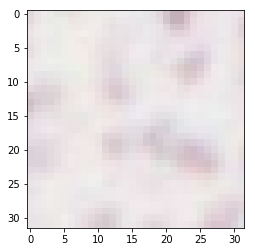

In [80]:
plt.imshow(example["targets"].numpy()[0])

In [81]:
example2 = example
example2["targets"] = tf.reshape(tf.zeros((1, 32, 32, 3), dtype=np.uint8), [1, 32, 32, 3])

In [82]:
ckpt_path = "/mnt/nfs-east1-d/comparisons/multigpu-4/multigpu-4-j0702-1923-8c15/output/master-0/model.ckpt-10000"
with tfe.restore_variables_on_create(ckpt_path):
  predictions, _ = model(example2)

In [83]:
import numpy as np

def infer(predictions):
    p = predictions.numpy()
    x_max = p.shape[1] # X-position in image
    y_max = p.shape[2] # Y-position in image
    c_max = p.shape[3] # Color channel (r,g,b)

    # The image we will populate
    image = np.zeros((1, x_max, y_max, c_max), dtype=np.uint8)

    batch_idx = 0

    for x in range(0, x_max):
        for y in range(0, y_max):
            for c in range(0, c_max):
                # Get the index of the greatest value in p[0][x][y][c]
                val = np.argmax(p[0][x][y][c])
                image[batch_idx][x][y][c] = np.uint8(np.argmax(p[0][x][y][c]))
    return image[0]


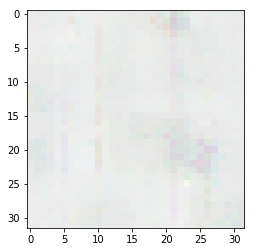

In [86]:
with tfe.restore_variables_on_create(ckpt_path):
  predictions, _ = model(example2)
  plt.imshow(infer(predictions))

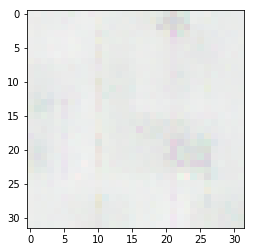

In [87]:
with tfe.restore_variables_on_create(ckpt_path):
  predictions, _ = model(example2)
  plt.imshow(infer(predictions))

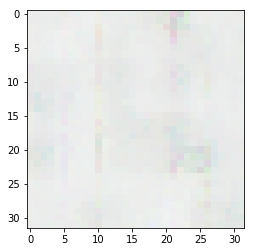

In [88]:
with tfe.restore_variables_on_create(ckpt_path):
  predictions, _ = model(example2)
  plt.imshow(infer(predictions))

In [109]:
def _predict_ith(offset):
    with tfe.restore_variables_on_create(ckpt_path):
      for count, example in enumerate(tfe.Iterator(dataset)):
          if count > offset:
            break
      fig=plt.figure(figsize=(8, 8))
      example["inputs"] = tf.reshape(example["inputs"], [1, 8, 8, 3])
      fig.add_subplot(1, 3, 1)
      plt.imshow(example["inputs"].numpy()[0])
      fig.add_subplot(1, 3, 2)
      example["targets"] = tf.reshape(example["targets"], [1, 32, 32, 3])
      plt.imshow(example["targets"].numpy()[0])
      example["targets"] = tf.reshape(tf.zeros((1, 32, 32, 3), dtype=np.uint8), [1, 32, 32, 3])
      predictions, _ = model(example)
      fig.add_subplot(1,3,3)
      plt.imshow(infer(predictions))
      plt.show()

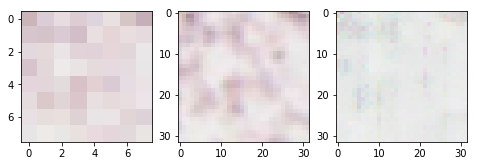

In [116]:
_predict_ith(1724)

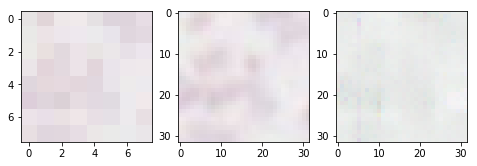

In [111]:
_predict_ith(1726)

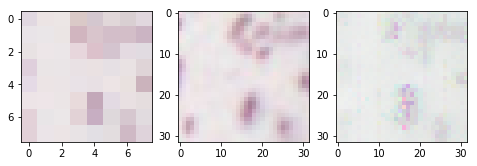

In [112]:
_predict_ith(1727)

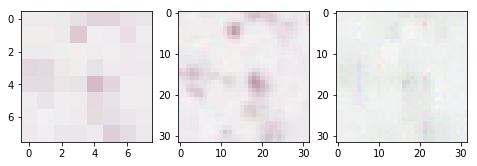

In [113]:
_predict_ith(1728)

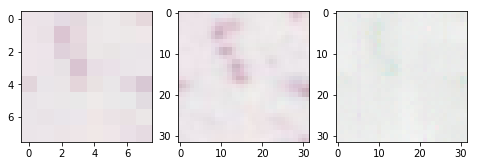

In [117]:
_predict_ith(1729)

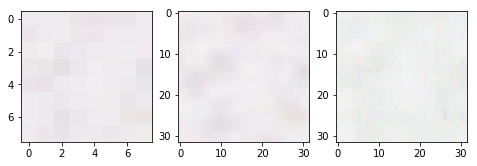

In [119]:
_predict_ith(1730)

In [211]:
# Getting there! 🎉

### Large image up-sampling by padded tiling

So here let's see about using an approach similar to that from the U-Net paper for stitching small image decodings into a large one